<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mlp.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mlp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Multilayer Perceptron (MLP)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu102].
device:[cuda:0].


### Dataset

In [ ]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Data Iterator

In [ ]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define the MLP model

In [ ]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self,name='mlp',xdim=784,hdim=256,ydim=10):
        super(MultiLayerPerceptronClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp',xdim=784,hdim=256,ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print ("Done.")

Done.


### Simple Forward Path of the MLP Model

In [ ]:
x_numpy = np.random.rand(2,784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_numpy:\n",x_numpy)
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("y_numpy:\n",y_numpy)

x_numpy:
 [[0.00692844 0.93843546 0.71319977 ... 0.54361457 0.13397623 0.03578765]
 [0.98558419 0.59878899 0.84277842 ... 0.90360178 0.64138654 0.09893796]]
x_torch:
 tensor([[0.0069, 0.9384, 0.7132,  ..., 0.5436, 0.1340, 0.0358],
        [0.9856, 0.5988, 0.8428,  ..., 0.9036, 0.6414, 0.0989]],
       device='cuda:0')
y_torch:
 tensor([[-1.0328, -1.4418, -1.7717, -1.2890, -1.2586, -0.1602,  1.1987, -0.0465,
          1.0576,  1.1146],
        [-0.9706, -1.1871, -1.5309, -1.0720, -1.2938, -0.2285,  0.7548, -0.1788,
          0.2800,  1.7307]], device='cuda:0', grad_fn=<AddmmBackward>)
y_numpy:
 [[-1.0328035  -1.4418435  -1.7716639  -1.288971   -1.258619   -0.16015442
   1.1987227  -0.04645123  1.0575833   1.1145761 ]
 [-0.9706245  -1.1870759  -1.5309478  -1.0719897  -1.2937901  -0.22847421
   0.7547915  -0.17878453  0.2800411   1.7306615 ]]


### Check Parameters

In [ ]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[lin_1.weight] shape:[(256, 784)].
    val:[ 0.04   0.082  0.009  0.013 -0.026]
[1] name:[lin_1.bias] shape:[(256,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[lin_2.weight] shape:[(10, 256)].
    val:[ 0.079 -0.071  0.08  -0.003  0.132]
[3] name:[lin_2.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[203,530].


### Evaluation Function

In [ ]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        model.eval() # evaluate (affects DropOut and BN)
        n_total,n_correct = 0,0
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 28*28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [12]:
M.init_param() # initialize parameters
train_accr = func_eval(M,train_iter,device)
test_accr = func_eval(M,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.107] test_accr:[0.114].


### Train

In [13]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device)
        test_accr = func_eval(M,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

Start training.
epoch:[0] loss:[0.388] train_accr:[0.945] test_accr:[0.943].
epoch:[1] loss:[0.169] train_accr:[0.963] test_accr:[0.958].
epoch:[2] loss:[0.120] train_accr:[0.973] test_accr:[0.968].
epoch:[3] loss:[0.090] train_accr:[0.980] test_accr:[0.971].
epoch:[4] loss:[0.073] train_accr:[0.985] test_accr:[0.976].
epoch:[5] loss:[0.059] train_accr:[0.988] test_accr:[0.977].
epoch:[6] loss:[0.048] train_accr:[0.990] test_accr:[0.978].
epoch:[7] loss:[0.040] train_accr:[0.992] test_accr:[0.978].
epoch:[8] loss:[0.034] train_accr:[0.994] test_accr:[0.978].
epoch:[9] loss:[0.028] train_accr:[0.995] test_accr:[0.980].
Done


### Test

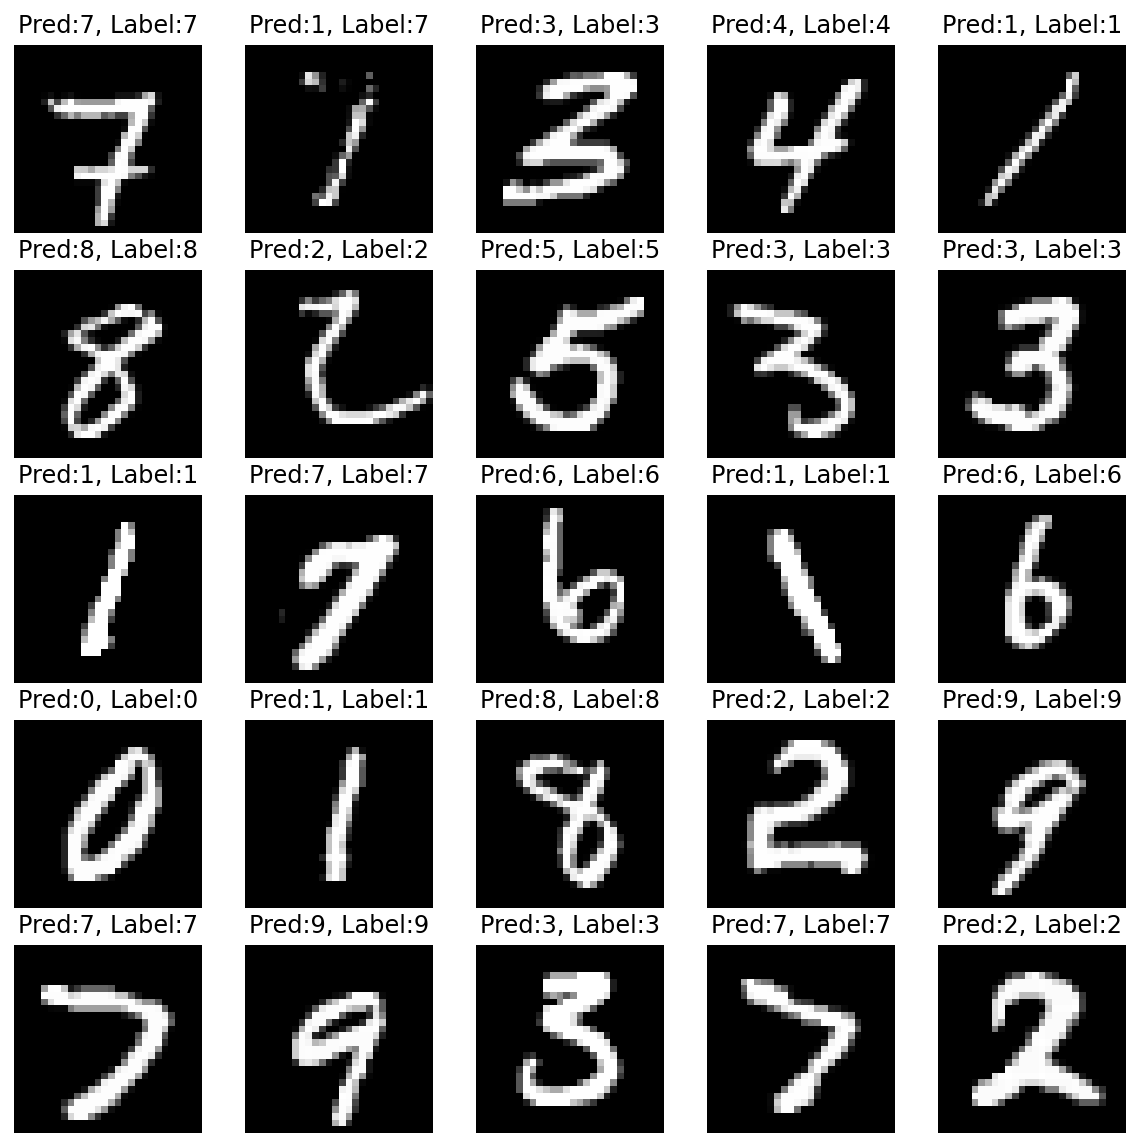

Done


In [14]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")